<a href="https://colab.research.google.com/github/virenvaghasiya/Deep_steganography_using_CNN_and_Machine_Learning_Techniques/blob/main/Deep_steganography_using_CNN_and_Machine_Learning_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Libraries**

In [ ]:
!pip install scipy
!pip install scikit-learn
!pip install opencv-python
!pip install tensorflow
!pip install scikeras
!pip install keras==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    U

**File Upload Utility**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"virenvaghasiya","key":"e800f68187848c18a08d1f049f133da4"}'}

**Create Kaggle API Directory**

In [ ]:
! mkdir ~/.kaggle

**Move Kaggle API Key**

In [ ]:
!cp kaggle.json ~/.kaggle

**Set Permissions for Kaggle Key**

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

**Download Dataset from Kaggle**

In [ ]:
!kaggle datasets download -d nikhilshingadiya/tinyimagenet200

Dataset URL: https://www.kaggle.com/datasets/nikhilshingadiya/tinyimagenet200
License(s): unknown
 99% 232M/235M [00:13<00:00, 21.9MB/s]
100% 235M/235M [00:13<00:00, 18.5MB/s]


**Data Preparation**

**Unzip the Dataset**

In [ ]:
!unzip tinyimagenet200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_5500.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5501.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5502.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5503.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5504.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5505.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5506.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5507.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5508.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5509.JPEG  
  inflating: tiny-imagenet-200/val/images/val_551.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5510.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5511.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5512.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5513.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5514.JPEG  
  inflating: tiny-imag

**Importing Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.preprocessing import OneHotEncoder
from scipy import ndimage
import cv2




# import tensorflow as tf
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.preprocessing import image
# import tensorflow.keras.backend as K
# from tensorflow.keras.datasets import mnist, cifar10
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import  ModelCheckpoint
# import numpy as np
# import os
# import random
# from tqdm import tqdm
# import pandas as pd





**Image Pre-Processing**

In [ ]:
import cv2
#from keras.optimizers import Adam
files = os.listdir('tiny-imagenet-200/train')
files_te = os.listdir('tiny-imagenet-200/test/images')
x_train = np.empty((2000,64,64,3), 'uint64')
a=0
for i in range(200):
  idd = np.random.randint(0, 500, 10)
  for j in range(10):
    image = cv2.imread('tiny-imagenet-200/train/'+files[i]+'/images/'+files[i]+'_'+str(idd[j])+'.JPEG')
    x_train[a] = image
    a=a+1
x_test = np.empty((2000,64,64,3), 'uint64')
a=0
for i in range(2000):
    image = cv2.imread('tiny-imagenet-200/test/images/'+files_te[i])
    x_test[a] = image
    a=a+1
input_S = x_train[0:1000]
input_C = x_train[1000:]
input_C = input_C/255.0
input_S = input_S/255.0

In [ ]:
input_C

array([[[[0.59215686, 0.58823529, 0.62745098],
         [0.54901961, 0.54509804, 0.58039216],
         [0.57647059, 0.56470588, 0.6       ],
         ...,
         [0.23529412, 0.2       , 0.16078431],
         [0.23921569, 0.20392157, 0.15294118],
         [0.23529412, 0.2       , 0.14901961]],

        [[0.58039216, 0.58431373, 0.62352941],
         [0.54901961, 0.55686275, 0.58823529],
         [0.57254902, 0.56862745, 0.60392157],
         ...,
         [0.26666667, 0.23137255, 0.19215686],
         [0.26666667, 0.22745098, 0.18823529],
         [0.25882353, 0.22352941, 0.17254902]],

        [[0.57254902, 0.58039216, 0.61960784],
         [0.55686275, 0.56862745, 0.6       ],
         [0.57647059, 0.58431373, 0.61568627],
         ...,
         [0.29803922, 0.25882353, 0.21960784],
         [0.29411765, 0.24705882, 0.20784314],
         [0.28627451, 0.23921569, 0.2       ]],

        ...,

        [[0.5254902 , 0.50980392, 0.50588235],
         [0.57647059, 0.56078431, 0.55686275]

**Define CNN Models for Steganography**

In [ ]:
def prep_and_hide_network(input_size):
  input_message = Input(shape=(input_size))
  input_cover = Input(shape=(input_size))

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(input_message)
  x2 = Conv2D(10, (4,4), strides = (1,1), padding = 'same', activation = 'relu')(input_message)
  x3 = Conv2D(5, (5,5), strides = (1,1), padding = 'same', activation = 'relu')(input_message)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (4,4), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (5,5), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  x = concatenate([input_cover,x])


  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (4,4), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (5,5), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (4,4), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (5,5), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (4,4), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (5,5), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (4,4), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (5,5), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (4,4), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (5,5), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  image_container = Conv2D(3, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)

  encoder = Model(inputs = [input_message, input_cover],
                  outputs = image_container)
  return encoder

In [ ]:
def reveal_network(input_size, fixed=False):
  reveal_input = Input(shape=(input_size))

  input_with_noise = GaussianNoise(0.01)(reveal_input)

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(input_with_noise)
  x2 = Conv2D(10, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(input_with_noise)
  x3 = Conv2D(5, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(input_with_noise)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  x1 = Conv2D(50, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x2 = Conv2D(10, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x3 = Conv2D(5, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)
  x = concatenate([x1, x2, x3])

  message = Conv2D(3, (3,3), strides = (1,1), padding = 'same', activation = 'relu')(x)

  reveal =  Model(inputs = reveal_input,
                  outputs = message)

  return reveal

**Define Loss Functions**

In [ ]:
beta = 1.0
def rev_loss(true,pred):
  loss = beta*K.sum(K.square(true-pred))
  return loss

def full_loss(true,pred):
  message_true, container_true = true[...,0:3], true[...,3:6]
  message_pred, container_pred = pred[...,0:3], pred[...,3:6]

  message_loss = rev_loss(message_true, message_pred)
  container_loss = K.sum(K.square(container_true-container_pred))

  loss = message_loss + container_loss
  return loss

**Compile and Setup Models**

In [ ]:
shape = input_S.shape[1:]

input_message = Input(shape = (shape))
input_container = Input(shape = (shape))

prep_and_hide = prep_and_hide_network(shape)
reveal = reveal_network(shape)

reveal.compile(optimizer = 'adam',
              loss = rev_loss)

reveal.trainable = False

output_container = prep_and_hide([input_message, input_container])
output_message = reveal(output_container)

deep_stean = Model(inputs = [input_message, input_container],
                outputs = concatenate([output_message, output_container]))

deep_stean.compile(optimizer = 'adam',
                  loss = full_loss)

**Display Model Summary**

In [ ]:
deep_stean.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 64, 64, 3)            293273    ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 64, 64, 3)            155938    ['model[0][0]']         

In [ ]:
from keras.optimizers import Adam

def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003


import numpy as np

# Initialize mean losses as lists
f_loss_mean = []
r_loss_mean = []
full_loss_history = []
reveal_loss_history = []

m = input_S.shape[0]
batch_size = 32
epochs = 100  # Total number of epochs
for epoch in range(epochs):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    itera = int(m / batch_size)

    # Reset mean losses for each epoch
    f_loss_mean = []
    r_loss_mean = []

    for i in range(itera):
        batch_message = input_S[i*batch_size:min((i+1)*batch_size, m)]
        batch_cover = input_C[i*batch_size:min((i+1)*batch_size, m)]

        container = prep_and_hide.predict([batch_message, batch_cover])

        f_loss = deep_stean.train_on_batch(x=[batch_message, batch_cover],
                                           y=np.concatenate((batch_message, batch_cover), axis=3))
        r_loss = reveal.train_on_batch(x=container,
                                       y=batch_message)

        # Append losses to lists
        f_loss_mean.append(f_loss)
        r_loss_mean.append(r_loss)

    # Calculate mean losses for the epoch
    f_loss_mean = np.mean(f_loss_mean)
    r_loss_mean = np.mean(r_loss_mean)

    # Append mean loss to history for plotting
    full_loss_history.append(f_loss_mean)
    reveal_loss_history.append(r_loss_mean)

    # Adjust learning rate based on the schedule
    K.set_value(deep_stean.optimizer.learning_rate, lr_schedule(epoch))
    K.set_value(reveal.optimizer.learning_rate, lr_schedule(epoch))

    #K.set_value(deep_stean.optimizer.lr, lr_schedule(epoch))
    #K.set_value(reveal.optimizer.lr, lr_schedule(epoch))

    print(f'Epoch = {epoch} | Mean full loss = {f_loss_mean} | Mean reveal loss = {r_loss_mean}')
    print('--------------------Epoch ' + str(epoch) + ' complete--------------------')

1/1 [==============================] - 0s 23ms/step
Epoch = 0 | Mean full loss = 170971.36731350806 | Mean reveal loss = 122132.36706149194
--------------------Epoch 0 complete--------------------
1/1 [==============================] - 0s 21ms/step
Epoch = 1 | Mean full loss = 37915.07213961693 | Mean reveal loss = 21588.946982106856
--------------------Epoch 1 complete--------------------
1/1 [==============================] - 0s 21ms/step
Epoch = 2 | Mean full loss = 30879.073462701614 | Mean reveal loss = 19626.9552671371
--------------------Epoch 2 complete--------------------
1/1 [==============================] - 0s 21ms/step
Epoch = 3 | Mean full loss = 20432.776650705644 | Mean reveal loss = 11633.726310483871
--------------------Epoch 3 complete--------------------
1/1 [==============================] - 0s 21ms/step
Epoch = 4 | Mean full loss = 17201.541708669356 | Mean reveal loss = 10230.810783140121
--------------------Epoch 4 complete--------------------
1/1 [=============

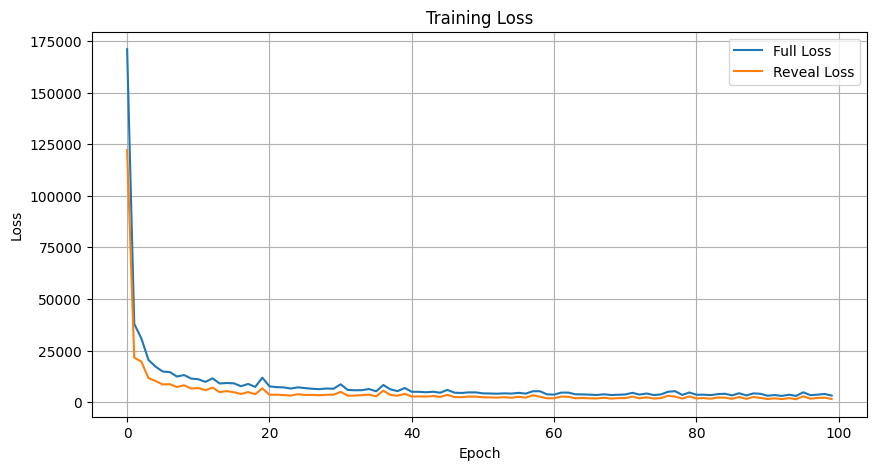

In [ ]:
import matplotlib.pyplot as plt

# Plotting the full loss and reveal loss
plt.figure(figsize=(10, 5))

# Plot full loss history
plt.plot(full_loss_history, label='Full Loss')
# Plot reveal loss history
plt.plot(reveal_loss_history, label='Reveal Loss')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
!pip install joblib
import joblib
#joblib.dump(deep_stean,'main_model')
deep_stean.save("deep_stean_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save model
# autoencoder_model.save_weights('models/model.hdf5')

In [ ]:
# Retrieve decoded predictions.
decoded = deep_stean.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

32/32 [==============================] - 3s 81ms/step


In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()

    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)

    imgplot = plt.hist(255* diff_Cflat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])

    plt.show()

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 13.912962330532814
C error per pixel [0, 255]: 16.244207327645128


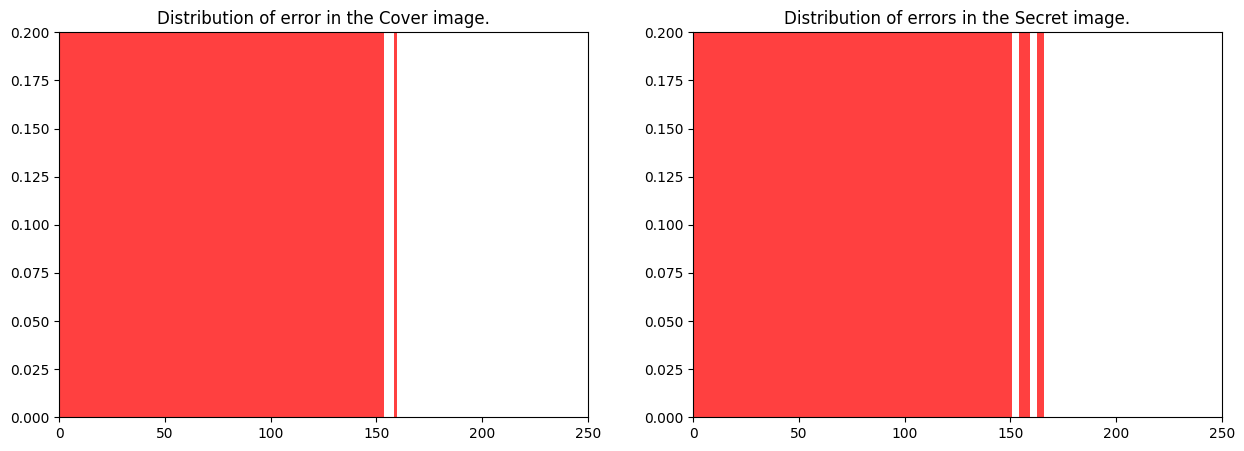

In [ ]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

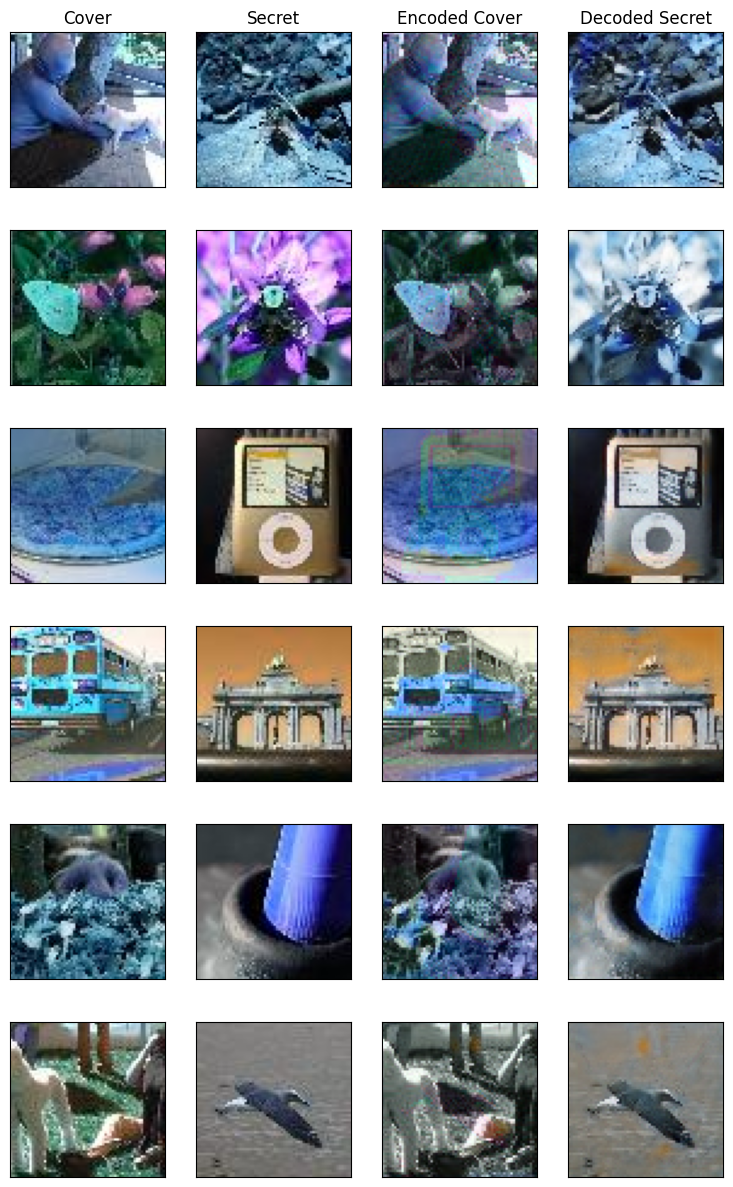

In [ ]:
# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4

    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')

    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')


    # if SHOW_DIFF:
    #    # show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')

    #     # show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()